In [24]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
        print("Setting GPU Memory Growth...")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import time
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import sklearn.metrics as metrics
import os as os

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.python.client import device_lib

import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization


print("TF version:", tf.__version__)
print("KT version:", kt.__version__)
print("Panda version:", pd.__version__)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Physical devices: ", tf.config.list_physical_devices())
# Se va a habilitar la dedicacion dinamica de memoria para que la GPU vaya asignando recursos al proceso conforme los vaya necesitando

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))
print("Build with CUDA: ", tf.test.is_built_with_cuda())

# Number of measurements to predict
numPredictions = 20

# Number of best models
numBestModels = 1 

# Validation set percentage
val_size = 0.3

# Batch size
batch = 1024

# Nodos internos
hidden_nodes = 10

# Units parameters
minUnits = 10
maxUnits = 50
stepsUnits = 10
defaultUnits = 30

# Layers parameters
minLayers = 1
maxLayers = 10
defaultLayers = 3

# Dropout Parameters
minDropout = 0
maxDropout = 0.33
defaultDropout = .25

# Establecer medida de loss
loss = "mean_absolute_error"

# Learning rate
learningRate = [0.0, 1e-2, 1e-3, 1e-4]

# Model metrics
modelMetrics = [keras.metrics.MAE, tf.keras.metrics.RootMeanSquaredError(name = 'rmse')]

# Optimizer objetive: error percetange with the validation set 
objective = kt.Objective('val_mean_absolute_error', 'min')

# Maximum model trials and executions
trials = 2
executions = 5

# Model saving parameters
workingDirectory = datetime.datetime.fromtimestamp(time.time()).strftime('%d-%m-%Y-%H:%M')
# projectName = "lstm"

Setting GPU Memory Growth...


c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\client\session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


TF version: 2.1.0
KT version: 1.0.1
Panda version: 1.1.5
Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0
Num GPUs Available:  1
Build with CUDA:  True


In [25]:
# X = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_PV_W20_H20.csv",
#                        delimiter=";")

# xTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_PV_W20_H20.csv",
#                    delimiter=";")

X = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_Weather_W7.csv",
                       delimiter=",")

xTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_Weather_W7.csv",
                   delimiter=",")

print(X)
print(xTest)

     min_temp_d1  max_temp_d1  rainfall_d1  sun_hours_d1  max_wind_speed_d1  \
0       0.919431     0.699029     0.001095      0.774436           0.261538   
1       0.909953     0.621359     0.006572      0.315789           0.369231   
2       0.744076     0.684466     0.092004      0.902256           0.230769   
3       0.777251     0.582524     0.000000      0.285714           0.138462   
4       0.763033     0.650485     0.118291      0.909774           0.338462   
..           ...          ...          ...           ...                ...   
354     0.767773     0.699029     0.000000      0.721805           0.200000   
355     0.729858     0.703883     0.000000      0.902256           0.261538   
356     0.729858     0.582524     0.017525      0.097744           0.261538   
357     0.677725     0.597087     0.050383      0.774436           0.230769   
358     0.644550     0.771845     0.002191      0.969925           0.200000   

     temp_9_d1  Rel_hum_9_d1  cloud_cover_d1  wind_

In [26]:
# Epochs
epchs = 1000

W=20
H=20
PV_index = 14


projectNameBO = "Weather_W7-lstm-bo"
projectNameRS = "Weather_W7-lstm-rs"

In [27]:
# Preprocessing for W type files:

# Filter for PV data
X = X.iloc[:, ::PV_index]
xTest = xTest.iloc[:, ::PV_index]

numPredictions = len(X.columns)

# Reset column names
new_column_names = [f'PV_{i+1}' for i in range(numPredictions)]
X.columns = new_column_names
xTest.columns = new_column_names

Y = pd.DataFrame.copy(X)
yTest = pd.DataFrame.copy(xTest)

# Create Y from taking next day data
Y = Y.drop(0)
Y = Y.reset_index(drop = True)
Y.loc[len(Y)] = np.zeros(numPredictions)

yTest = yTest.drop(0)
yTest = yTest.reset_index(drop = True)
yTest.loc[len(yTest)] = np.zeros(numPredictions)

print(X)
print(yTest)

         PV_1      PV_2      PV_3      PV_4      PV_5      PV_6      PV_7
0    0.919431  0.909953  0.744076  0.777251  0.763033  0.720379  0.682464
1    0.909953  0.744076  0.777251  0.763033  0.720379  0.682464  0.729858
2    0.744076  0.777251  0.763033  0.720379  0.682464  0.729858  0.791469
3    0.777251  0.763033  0.720379  0.682464  0.729858  0.791469  0.853081
4    0.763033  0.720379  0.682464  0.729858  0.791469  0.853081  0.810427
..        ...       ...       ...       ...       ...       ...       ...
354  0.767773  0.729858  0.729858  0.677725  0.644550  0.862559  0.696682
355  0.729858  0.729858  0.677725  0.644550  0.862559  0.696682  0.620853
356  0.729858  0.677725  0.644550  0.862559  0.696682  0.620853  0.649289
357  0.677725  0.644550  0.862559  0.696682  0.620853  0.649289  0.663507
358  0.644550  0.862559  0.696682  0.620853  0.649289  0.663507  0.649289

[359 rows x 7 columns]
         PV_1      PV_2      PV_3      PV_4      PV_5      PV_6      PV_7
0    0.739336 

In [28]:
# # Old Data preprocessing: each row will contain the 20 measures for each day , and the 10 measures for the following day
# # X = pd.DataFrame(np.array(training).reshape(-1, W))
# Y = pd.DataFrame.copy(X)
# yTest = pd.DataFrame.copy(xTest)

# Y.columns = ["col_{}".format(i) for i in range(W+1, (2*W)+1)]
# Y = Y.drop(0)
# Y = Y.reset_index(drop = True)
# Y.loc[len(Y)] = np.zeros(numPredictions)

# # Last row is deleted because it is the one used for the real prediction, 
# # it is not useful for the training of the model. 
# X.drop(X.tail(1).index, inplace = True)
# Y.drop(Y.tail(1).index, inplace = True)

# print("X Preproccessed shape: ", X.shape)
# print("Y Preproccessed shape: ", Y.shape)
# print("---------------------------------------------")

# #  Uncomment in order to normalize data
# # Data Normalization
# # scaler = MinMaxScaler()
# # X = pd.DataFrame(scaler.fit_transform(X), columns=["col_{}".format(i) for i in range(1, 21)])
# # Y = pd.DataFrame(scaler.fit_transform(Y), columns=["col_{}".format(i) for i in range(21, 41)])

In [29]:
dfPreproccessed = pd.concat([X, Y], axis = 1)

print("DataFrame Preproccessed:")
print(dfPreproccessed)
print("---------------------------------------------")

# Split the data into training and validation sets
xTrain, xVal, yTrain, yVal = train_test_split(X, 
                                            Y, 
                                            test_size = val_size, 
                                            random_state = 0, 
                                            shuffle=False)

# Adding the third dimension needed to use LSTM (samples, timestamps, features)
xtrain = np.reshape(xTrain.values, (xTrain.shape[0], xTrain.shape[1], 1))
ytrain = np.reshape(yTrain.values, (yTrain.shape[0], yTrain.shape[1], 1))
xval = np.reshape(xVal.values, (xVal.shape[0], xVal.shape[1], 1))
yval = np.reshape(yVal.values, (yVal.shape[0], yVal.shape[1], 1))
xtest = np.reshape(xTest.values, (xTest.shape[0], xTest.shape[1], 1))
ytest = np.reshape(yTest.values, (yTest.shape[0], yTest.shape[1], 1))

# New shapes after third dimension added
print("Dimensions afther third dimension added:")
print("xTrain:\t"+str(xtrain.shape))
print("yTrain:\t"+str(ytrain.shape))
print("xVal:\t"+str(xval.shape))
print("yVal:\t"+str(yval.shape))
print("xTest:\t"+str(xTest.shape))
print("yTest:\t"+str(yTest.shape))

validation_data = xval.reshape((xval.shape[0], xval.shape[1]))

DataFrame Preproccessed:
         PV_1      PV_2      PV_3      PV_4      PV_5      PV_6      PV_7  \
0    0.919431  0.909953  0.744076  0.777251  0.763033  0.720379  0.682464   
1    0.909953  0.744076  0.777251  0.763033  0.720379  0.682464  0.729858   
2    0.744076  0.777251  0.763033  0.720379  0.682464  0.729858  0.791469   
3    0.777251  0.763033  0.720379  0.682464  0.729858  0.791469  0.853081   
4    0.763033  0.720379  0.682464  0.729858  0.791469  0.853081  0.810427   
..        ...       ...       ...       ...       ...       ...       ...   
354  0.767773  0.729858  0.729858  0.677725  0.644550  0.862559  0.696682   
355  0.729858  0.729858  0.677725  0.644550  0.862559  0.696682  0.620853   
356  0.729858  0.677725  0.644550  0.862559  0.696682  0.620853  0.649289   
357  0.677725  0.644550  0.862559  0.696682  0.620853  0.649289  0.663507   
358  0.644550  0.862559  0.696682  0.620853  0.649289  0.663507  0.649289   

         PV_1      PV_2      PV_3      PV_4      P

In [30]:
# Model definition:
with tf.device('/gpu:0'): 
    
    def build_model(hp): 

        model = Sequential()
        
        # model.add(LSTM(hidden_nodes, input_shape=(xtrain.shape[1], 1)))
        # First layer: LSTM. Number of units optimization
        model.add(LSTM(units = hp.Int('units', 
                                    min_value = minUnits,
                                    max_value = maxUnits, 
                                    step = stepsUnits,
                                    default = defaultUnits),
                        return_sequences = True, 
                        input_shape = (xtrain.shape[1], xtrain.shape[2])))

        # Second layer: Dropout with percetange optimization
        model.add(
            Dropout(hp.Float('dropout', 
                            min_value = minDropout,
                            max_value = maxDropout,
                            default = defaultDropout)))
        
        # Last layer:
        model.add(Dense(numPredictions))

        print("Summary: ")
        model.summary()

        # Model compilation: learning rate optimization
        model.compile(loss = loss,
                    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', 
                                                                values = learningRate)),
                    metrics = modelMetrics)

        return model

In [31]:
# Model training:
with tf.device('/gpu:0'): 
    # # Create optimizer using Random Search
    # lstmOptimizer = RandomSearch(build_model, 
    #                             objective = objective,
    #                             max_trials = trials, 
    #                             executions_per_trial = executions,
    #                             project_name = projectName,
    #                             overwrite=True)
    
    # Create optimizer using Bayesian Optimization 
    lstmOptimizer = BayesianOptimization(build_model, 
                                objective = objective,
                                max_trials = trials, 
                                executions_per_trial = executions,
                                project_name = projectNameBO,
                                overwrite=True)

    # Search space summary
    lstmOptimizer.search_space_summary()

    # Search execution with epochs
    initialTime = time.time()
    lstmOptimizer.search(x = xtrain,
                        y = ytrain, 
                        epochs = epchs,
                        batch_size = batch,
                        validation_data = (xval.reshape((xval.shape[0], xval.shape[1], 1)), yval))
    finalTime = time.time()

    # Results summary
    lstmOptimizer.results_summary()

    # Get best model generated
    model = lstmOptimizer.get_best_models(num_models = numBestModels)[0]

    # Model training with epochs 
    history = model.fit(
                xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1)),
                ytrain,
                epochs = epchs,
                batch_size = batch,
                validation_data = (xval.reshape((xval.shape[0], xval.shape[1], 1)), yval))

    # Show model info
    print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))
    print("Tiempo de entrenamiento (en horas):\t"+str((finalTime - initialTime)/3600))
    print(history.history.keys())
    print(model.history.history)
    print(model.history.params)

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 30)             3840      
_________________________________________________________________
dropout (Dropout)            (None, 7, 30)             0         
_________________________________________________________________
dense (Dense)                (None, 7, 7)              217       
Total params: 4,057
Trainable params: 4,057
Non-trainable params: 0
_________________________________________________________________


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 40)             6720      
_________________________________________________________________
dropout (Dropout)            (None, 7, 40)             0         
_________________________________________________________________
dense (Dense)                (None, 7, 7)              287       
Total params: 7,007
Trainable params: 7,007
Non-trainable params: 0
_________________________________________________________________
Train on 251 samples, validate on 108 samples
Epoch 1/1000
251/251 [==============================] - 1s 5ms/sample - loss: 0.4768 - mean_absolute_error: 0.4768 - rmse: 0.5324 - val_loss: 0.5608 - val_mean_absolute_error: 0.5608 - val_rmse: 0.5842
Epoch 2/1000
251/251 [==============================] - 0s 64us/sample - loss: 0.4771 - mean_absolute_error: 0.4771 - rmse: 0.

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 30)             3840      
_________________________________________________________________
dropout (Dropout)            (None, 7, 30)             0         
_________________________________________________________________
dense (Dense)                (None, 7, 7)              217       
Total params: 4,057
Trainable params: 4,057
Non-trainable params: 0
_________________________________________________________________
Train on 251 samples, validate on 108 samples
Epoch 1/1000
251/251 [==============================] - 1s 5ms/sample - loss: 0.4580 - mean_absolute_error: 0.4580 - rmse: 0.5122 - val_loss: 0.4735 - val_mean_absolute_error: 0.4735 - val_rmse: 0.5005
Epoch 2/1000
251/251 [==============================] - 0s 163us/sample - loss: 0.3992 - mean_absolute_error: 0.3992 - rmse: 0

INFO:tensorflow:Oracle triggered exit


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 30)             3840      
_________________________________________________________________
dropout (Dropout)            (None, 7, 30)             0         
_________________________________________________________________
dense (Dense)                (None, 7, 7)              217       
Total params: 4,057
Trainable params: 4,057
Non-trainable params: 0
_________________________________________________________________
Train on 251 samples, validate on 108 samples
Epoch 1/1000
251/251 [==============================] - 1s 5ms/sample - loss: 0.0701 - mean_absolute_error: 0.0701 - rmse: 0.0946 - val_loss: 0.0716 - val_mean_absolute_error: 0.0716 - val_rmse: 0.1047
Epoch 2/1000
251/251 [==============================] - 0s 98us/sample - loss: 0.0701 - mean_absolute_error: 0.0701 - rmse: 0.

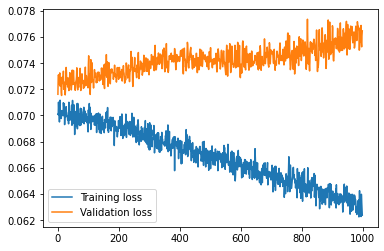

360/360 [==============================] - ETA: 0s - loss: 0.0649 - mean_absolute_error: 0.0649 - rmse: 0.07 - 0s 121us/sample - loss: 0.0824 - mean_absolute_error: 0.0824 - rmse: 0.1158
Score: [0.08236112429036034, 0.082361124, 0.11577059]


In [32]:
# Model evaluation:

# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(xtest.reshape((xtest.shape[0], xtest.shape[1], 1)), ytest)
print('Score:', score)

In [33]:
# Model training:
with tf.device('/gpu:0'): 
    # Create optimizer using Random Search
    lstmOptimizer = RandomSearch(build_model, 
                                objective = objective,
                                max_trials = trials, 
                                executions_per_trial = executions,
                                project_name = projectNameRS,
                                overwrite=True)

    # Search space summary
    lstmOptimizer.search_space_summary()

    # Search execution with epochs
    initialTime = time.time()
    lstmOptimizer.search(x = xtrain,
                        y = ytrain, 
                        epochs = epchs,
                        batch_size = batch,
                        validation_data = (xval.reshape((xval.shape[0], xval.shape[1], 1)), yval))
    finalTime = time.time()

    # Results summary
    lstmOptimizer.results_summary()

    # Get best model generated
    model = lstmOptimizer.get_best_models(num_models = numBestModels)[0]

    # Model training with epochs 
    history = model.fit(
                xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1)),
                ytrain,
                epochs = epchs,
                batch_size = batch,
                validation_data = (xval.reshape((xval.shape[0], xval.shape[1], 1)), yval))

    # Show model info
    print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))
    print("Tiempo de entrenamiento (en horas):\t"+str((finalTime - initialTime)/3600))
    print(history.history.keys())
    print(model.history.history)
    print(model.history.params)

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 30)             3840      
_________________________________________________________________
dropout (Dropout)            (None, 7, 30)             0         
_________________________________________________________________
dense (Dense)                (None, 7, 7)              217       
Total params: 4,057
Trainable params: 4,057
Non-trainable params: 0
_________________________________________________________________


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 30)             3840      
_________________________________________________________________
dropout (Dropout)            (None, 7, 30)             0         
_________________________________________________________________
dense (Dense)                (None, 7, 7)              217       
Total params: 4,057
Trainable params: 4,057
Non-trainable params: 0
_________________________________________________________________
Train on 251 samples, validate on 108 samples
Epoch 1/1000
251/251 [==============================] - 1s 4ms/sample - loss: 0.5252 - mean_absolute_error: 0.5252 - rmse: 0.5842 - val_loss: 0.5641 - val_mean_absolute_error: 0.5641 - val_rmse: 0.5874
Epoch 2/1000
251/251 [==============================] - 0s 203us/sample - loss: 0.4771 - mean_absolute_error: 0.4771 - rmse: 0

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 40)             6720      
_________________________________________________________________
dropout (Dropout)            (None, 7, 40)             0         
_________________________________________________________________
dense (Dense)                (None, 7, 7)              287       
Total params: 7,007
Trainable params: 7,007
Non-trainable params: 0
_________________________________________________________________
Train on 251 samples, validate on 108 samples
Epoch 1/1000
251/251 [==============================] - 1s 5ms/sample - loss: 0.5080 - mean_absolute_error: 0.5080 - rmse: 0.5667 - val_loss: 0.5900 - val_mean_absolute_error: 0.5900 - val_rmse: 0.6148
Epoch 2/1000
251/251 [==============================] - 0s 176us/sample - loss: 0.5020 - mean_absolute_error: 0.5020 - rmse: 0

INFO:tensorflow:Oracle triggered exit


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 30)             3840      
_________________________________________________________________
dropout (Dropout)            (None, 7, 30)             0         
_________________________________________________________________
dense (Dense)                (None, 7, 7)              217       
Total params: 4,057
Trainable params: 4,057
Non-trainable params: 0
_________________________________________________________________
Train on 251 samples, validate on 108 samples
Epoch 1/1000
251/251 [==============================] - 1s 5ms/sample - loss: 0.0706 - mean_absolute_error: 0.0706 - rmse: 0.0952 - val_loss: 0.0716 - val_mean_absolute_error: 0.0716 - val_rmse: 0.1047
Epoch 2/1000
251/251 [==============================] - 0s 78us/sample - loss: 0.0703 - mean_absolute_error: 0.0703 - rmse: 0.

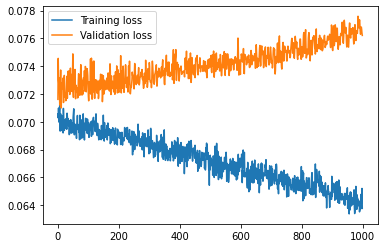

360/360 [==============================] - ETA: 0s - loss: 0.0676 - mean_absolute_error: 0.0676 - rmse: 0.07 - 0s 78us/sample - loss: 0.0805 - mean_absolute_error: 0.0805 - rmse: 0.1119
Score: [0.08051578369405535, 0.08051579, 0.11190173]


In [34]:
# Model evaluation:

# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(xtest.reshape((xtest.shape[0], xtest.shape[1], 1)), ytest)
print('Score:', score)